# S82 QSO lightcurves (9258) from MacLeod et al 2011 Catalog
spectroscopically confirmed QSOs in the SDSS DR7 stripe 82 (22h 24m < R.A. < 04h 08m and | Dec | < 1.27 deg, about 290 deg2)
http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html

In [1]:
import pdb
import os as os
import random
import pickle
import pandas as pd
import numpy as np
import math

#KALI for stochatic modelling
#import kali.s82
import kali.carma
import kali.util.mcmcviz as mcmcviz
from kali.util.mpl_settings import set_plot_params
import kali.util.triangle as triangle
import kali.csvLC


#Plotting 
import matplotlib.pyplot as plt
import matplotlib
#import richardsplot as rplot
%matplotlib inline

# Previewing Files

In [2]:
import glob 
lcs = glob.glob("../lightcurves/*")

In [3]:
names = ['MJD_u','u','u_err','MJD_g','g','g_err',
        'MJD_r','r','r_err','MJD_i','i','i_err',
        'MJD_z','z','z_err','ra_median','decl_median']
test = pd.read_csv(lcs[0], delimiter = ' ',names=names)
test[:10]

,MJD_u,u,u_err,MJD_g,g,g_err,MJD_r,r,r_err,MJD_i,i,i_err,MJD_z,z,z_err,ra_median,decl_median
0,51075.367187,20.883,0.074,51075.368853,20.985,0.032,51075.365520,20.547,0.031,51075.366353,20.552,0.050,51075.368020,20.536,0.244,24.307223,0.28012
1,52170.387853,20.988,0.086,52170.389519,21.082,0.033,52170.386186,20.656,0.032,52170.387019,20.618,0.045,52170.388686,20.513,0.190,24.307223,0.28012
2,52196.386450,21.010,0.113,52196.388116,20.975,0.037,52196.384783,20.619,0.038,52196.385616,20.638,0.059,52196.387283,20.349,0.214,24.307223,0.28012
3,52207.353148,20.916,0.092,52207.354814,20.946,0.033,52207.351481,20.514,0.032,52207.352314,20.544,0.044,52207.353981,20.782,0.234,24.307223,0.28012
4,52224.281342,20.936,0.085,52224.283008,20.819,0.027,52224.279675,20.544,0.029,52224.280508,20.510,0.038,52224.282175,20.522,0.163,24.307223,0.28012
5,52231.266772,20.695,0.075,52231.268438,20.736,0.029,52231.265105,20.522,0.030,52231.265938,20.418,0.037,52231.267605,20.760,0.244,24.307223,0.28012
6,52234.237861,20.640,0.072,52234.239527,20.769,0.027,52234.236194,20.437,0.028,52234.237027,20.492,0.039,52234.238694,20.688,0.190,24.307223,0.28012
7,52261.201216,20.534,0.076,52261.202882,20.582,0.025,52261.199549,20.392,0.034,52261.200382,20.306,0.043,52261.202049,20.368,0.177,24.307223,0.28012
8,52282.127845,-99.990,0.072,52282.129511,20.623,0.029,52282.126178,20.354,0.032,52282.127011,20.283,0.042,52282.128678,20.541,0.217,24.307223,0.28012
9,52287.081709,20.501,0.063,52287.083375,20.573,0.027,52287.080042,20.331,0.032,52287.080875,20.159,0.035,52287.082542,20.301,0.169,24.307223,0.28012


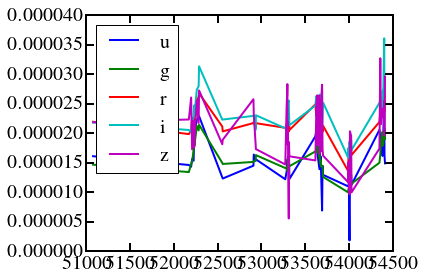

In [4]:
@np.vectorize
def luptitude_to_flux(mag, err, band):  # Converts a Luptitude to an SDSS flux
    b_ = dict(u=1.4e-10, g=0.9e-10, r=1.2e-10, i=1.8e-10, z=7.4e-10)
    f0 = 3631.0  # Jy
    flux = math.sinh(math.log(10.0)/-2.5*mag-math.log(b_[band]))*2*b_[band]*f0
    error = err*math.log(10)/2.5*2*b_[band]*math.sqrt(1+(flux/(2*b_[band]*f0))**2)*f0
    return flux, error

def previewBands(test, labels = False):
    bands = ['u','g','r','i','z']
    for c, v in enumerate(bands):
        mask = (test[v] > -99) & (test[v+'_err'] < 99)
        flux, error = luptitude_to_flux(test[v][mask], test[v+'_err'][mask], v)
        f = plt.plot(test['MJD_'+v][mask], flux, label = v)
        if labels == True:
            plt.legend(loc = 'best')
        plt.tight_layout()
 
previewBands(test, labels = True)

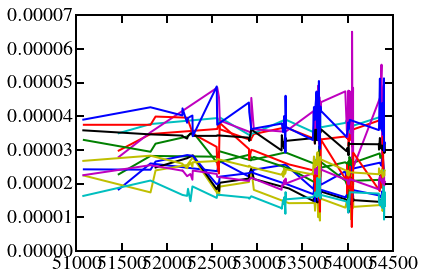

In [6]:
random = np.random.choice(len(lcs),3)

for c, value in enumerate(random):
    test = pd.read_csv(lcs[value], delimiter = ' ',names=names)
    previewBands(test)                      

# Previewing DRW results from MacLeod 2011

In [117]:
band = 'r'
columns = ['SDR5ID', 'ra', 'dec', 'redshift', 'M_i', 'mass_BH', 'chi2_pdf', 'log10tau', 
           'log10sigma', 'log10tau_lim_lo', 'log10tau_lim_hi',
           'log10sig_lim_lo', 'log10sig_lim_hi', 
           'edge_flag' ,'Plike',
           'Pnoise' , 'Pinf' , 'mu' , 'npts']
data = np.loadtxt('../s82drw/s82drw_'+ str(band)+'.dat',skiprows=3)
drwDB = pd.DataFrame(data, columns = columns)
#drwDB.SDR5ID = drwDB.SDR5ID.astype(int)

In [136]:
drwDB[:5]

,SDR5ID,ra,dec,redshift,M_i,mass_BH,chi2_pdf,log10tau,log10sigma,log10tau_lim_lo,log10tau_lim_hi,log10sig_lim_lo,log10sig_lim_hi,edge_flag,Plike,Pnoise,Pinf,mu,npts
0,301.0,2.169302,1.238649,1.0730,-23.901,0.000,1.192600,1.90162,-0.686379,1.70316,3.08136,-0.957464,-0.627884,0.0,138.926,117.2180,136.073,20.2857,60.0
1,144.0,1.091028,0.962126,0.7867,-23.399,0.000,1.278570,2.72909,-0.717700,2.61830,4.47248,-0.840168,-0.660262,0.0,123.092,75.9121,122.524,19.8702,52.0
2,58.0,0.331289,0.177230,1.6199,-24.735,0.000,1.194070,2.44022,-0.848145,2.24434,4.12020,-1.022690,-0.781607,0.0,134.360,107.7100,132.865,20.3141,57.0
3,190.0,1.364696,-0.098956,0.6125,-23.121,0.000,1.124260,2.87294,-0.627733,2.72995,4.49924,-0.719803,-0.591494,0.0,152.593,82.2158,152.094,19.4742,62.0
4,36.0,0.221552,-0.292485,2.7563,-26.451,9.361,0.896713,2.53532,-1.155490,2.33730,4.25247,-1.323420,-1.076520,0.0,167.706,147.0800,166.563,19.5994,56.0


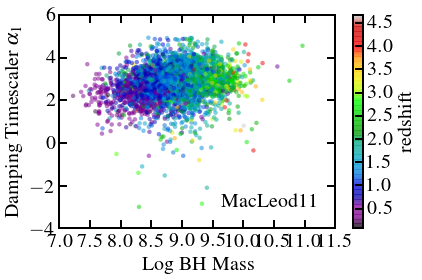

In [141]:
mask999 = (drwDB.mass_BH >0)&(drwDB.log10tau <5) & (drwDB.log10tau >-5)
plt.scatter(drwDB.mass_BH[mask999], drwDB.log10tau[mask999] ,c = drwDB.redshift[mask999], 
            cmap = 'nipy_spectral', alpha = 0.5, linewidth = 0, label = 'MacLeod11')
plt.colorbar(label = 'redshift')
plt.xlabel('Log BH Mass')
plt.ylabel('Damping Timescaler')
plt.legend(loc='lower right',frameon=False,markerscale=0)
plt.tight_layout()

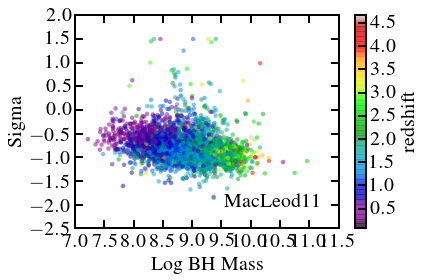

In [139]:

plt.scatter(drwDB.mass_BH[mask999], drwDB.log10sigma[mask999] ,c = drwDB.redshift[mask999], 
            cmap = 'nipy_spectral', alpha = 0.5, linewidth = 0, label = 'MacLeod11')
plt.colorbar(label = 'redshift')
plt.xlabel('Log BH Mass')
plt.ylabel('Sigma')
plt.legend(loc='lower right',frameon=False,markerscale=0)
plt.tight_layout()

# Color lightcurves

In [22]:
def colorLightcurves(test, labels = False):
    bands = ['u','g','r','i','z']

    v0 = bands[0]
    v1 = bands[1]
    mask = (test[v0] > -99) & (test[v0+'_err'] < 99) & (test[v1] > -99) & (test[v1+'_err'] < 99)
    fluxu, erroru = luptitude_to_flux(test[v0][mask], test[v0+'_err'][mask], v0)
    fluxg, errorg = luptitude_to_flux(test[v1][mask], test[v1+'_err'][mask], v1)
    ugflux, ugerr = np.log(fluxu/fluxg), np.sqrt(erroru**2 + errorg**2)
    
    
    #grflux, grerr = luptitude_to_flux(test[v][mask], test[v+'_err'][mask], v)

    f = plt.plot(test['MJD_'+v0][mask], ugflux, label = v0+'-'+v1)
    if labels == True:
        plt.legend(loc = 'best')
    plt.tight_layout()

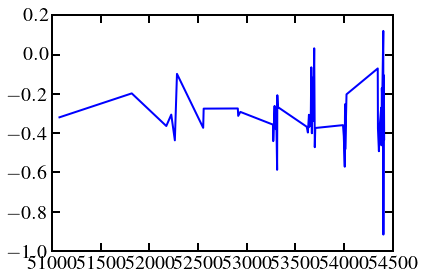

In [23]:
test = pd.read_csv(lcs[value], delimiter = ' ',names=names)
colorLightcurves(test)


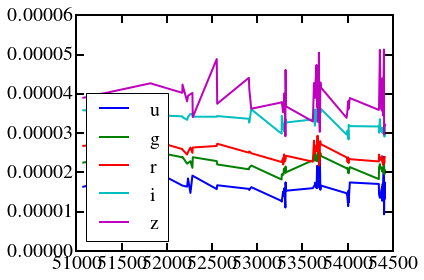

In [17]:
previewBands(test, labels=True)